## Get Data

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv('../input/train_set.csv')
val_df = pd.read_csv ('../input/val_set.csv')
test_df = pd.read_csv('../input/test_set.csv')

In [3]:
print(f'Train Set Shape: {train_df.shape}')
print(f'Validation Set Shape: {val_df.shape}')
print(f'Test Set Shape: {test_df.shape}')

Train Set Shape: (6000, 7)
Validation Set Shape: (1000, 7)
Test Set Shape: (1000, 7)


## Prepare Data

### Train a FastText Model on Data

In [4]:
from gensim.models import FastText

In [5]:
# Size of pretrained embedding
embedding_size = 100

# Word Limit for each input document
max_words = 100

In [6]:
train_sentences = train_df['News Text'].apply(lambda x: x.split()).to_list()

In [7]:
fasttext_model = FastText(sentences=train_sentences, vector_size=embedding_size, window=5, min_count=1, workers=4)

### Representing Each Article as a Vector

In [8]:
import numpy as np

In [9]:
def get_embedding(word):
    try:
        return fasttext_model.wv[word]
    except KeyError:  
        return np.zeros(embedding_size)

def get_article_tensor(article):
    words = article.split()
    word_embeddings = [get_embedding(word) for word in words[:max_words]] 
    
    if len(word_embeddings) < max_words:  # Pad if needed
        word_embeddings += [np.zeros(embedding_size)] * (max_words - len(word_embeddings))
    return np.array(word_embeddings)

In [10]:
# Get Feature Matrix
train_x = np.array([get_article_tensor(article) for article in train_df['News Text']])

val_x = np.array([get_article_tensor(article) for article in val_df['News Text']])

test_x = np.array([get_article_tensor(article) for article in test_df['News Text']])

In [11]:
print(f'Train Features: {train_x.shape}')
print(f'Validation Features Shape: {val_x.shape}')
print(f'Test Features Shape: {test_x.shape}')

Train Features: (6000, 100, 100)
Validation Features Shape: (1000, 100, 100)
Test Features Shape: (1000, 100, 100)


### Get Label Data

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
encoder = LabelEncoder()
train_y = encoder.fit_transform(train_df["Category"])
val_y = encoder.transform (val_df["Category"])
test_y = encoder.transform (test_df["Category"])

In [14]:
print(f'train_y shape: {train_y.shape}')
print(f'test_y shape: {val_y.shape}')
print(f'test_y shape: {test_y.shape}')

train_y shape: (6000,)
test_y shape: (1000,)
test_y shape: (1000,)


# Model Training

In [16]:
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM

### Function to Plot Losses

In [17]:
import matplotlib.pyplot as plt

def plot_losses(history):
    
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    epochs = range(len(train_loss))
    
    # Plot
    plt.plot(epochs, train_loss, label="Training Loss", color="blue")
    plt.plot(epochs, val_loss, label="Validation Loss", color="red")

    # Labels and legend
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()

### Early Stopping Callback

In [18]:
from keras.callbacks import EarlyStopping

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,
    restore_best_weights=True
)

## Model 1

In [22]:
# create model
model_1 = Sequential()
model_1.add(Input(shape=(max_words, embedding_size)))
model_1.add(LSTM(6, dropout=0.2, recurrent_dropout=0.2))
model_1.add(Dense(4, activation='sigmoid'))
model_1.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [23]:
history_1 = model_1.fit(train_x, train_y, epochs=40, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.5710 - loss: 1.0590 - val_acc: 0.8270 - val_loss: 0.5605
Epoch 2/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.8153 - loss: 0.5636 - val_acc: 0.8650 - val_loss: 0.4187
Epoch 3/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.8715 - loss: 0.4183 - val_acc: 0.9110 - val_loss: 0.3379
Epoch 4/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.8899 - loss: 0.3706 - val_acc: 0.9150 - val_loss: 0.3213
Epoch 5/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9014 - loss: 0.3289 - val_acc: 0.9200 - val_loss: 0.3025
Epoch 6/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9021 - loss: 0.3227 - val_acc: 0.9140 - val_loss: 0.3179
Epoch 7/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9099 - loss: 0.3205 - val_acc: 0.8950 - val_loss: 0.3257
Epoch 8/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9155 - loss: 0.3022 - val_acc: 0.9260 - val_loss: 0.2821
Epoch 9/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/

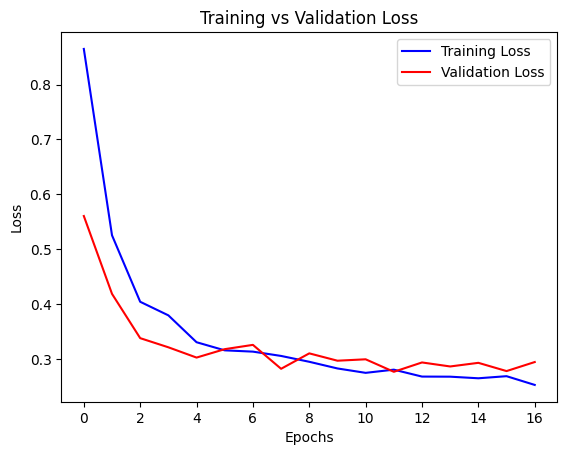

In [24]:
plot_losses(history_1)

### Conclusion: Adding dropout and recurretn dropout do not improve the best model found previously

## Model 2

### Reduce values for dropout

In [25]:
# create model
model_2 = Sequential()
model_2.add(Input(shape=(max_words, embedding_size)))
model_2.add(LSTM(6, dropout=0.1, recurrent_dropout=0.2))
model_2.add(Dense(4, activation='sigmoid'))
model_2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [26]:
history_2 = model_2.fit(train_x, train_y, epochs=40, batch_size=8, validation_data=(val_x, val_y))

Epoch 1/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.5813 - loss: 1.0714 - val_acc: 0.8820 - val_loss: 0.4768
Epoch 2/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.8575 - loss: 0.4959 - val_acc: 0.8980 - val_loss: 0.3618
Epoch 3/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.8903 - loss: 0.3775 - val_acc: 0.9060 - val_loss: 0.3384
Epoch 4/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.8979 - loss: 0.3739 - val_acc: 0.8880 - val_loss: 0.3679
Epoch 5/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.8896 - loss: 0.3722 - val_acc: 0.9110 - val_loss: 0.3070
Epoch 6/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9063 - loss: 0.3239 - val_acc: 0.9100 - val_loss: 0.3009
Epoch 7/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9068 - loss: 0.3143 - val_acc: 0.9230 - val_loss: 0.2734
Epoch 8/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9231 - loss: 0.2831 - val_acc: 0.9260 - val_loss: 0.2709
Epoch 9/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/

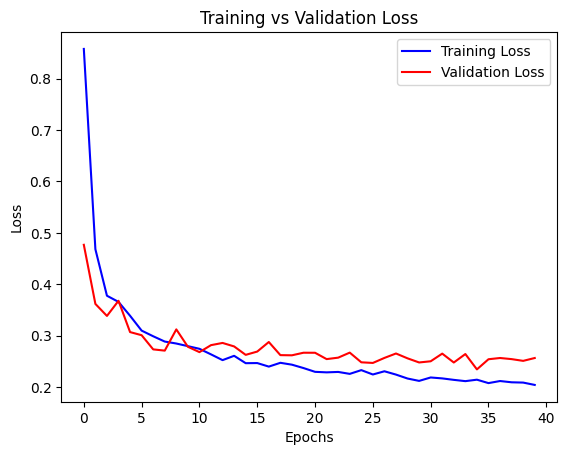

In [27]:
plot_losses(history_2)

### Conclusion: Reducing the input dropout value improves performance, bringing it up to par with the best model without dropout

## Model 3

### Increase Recurrent dropout

In [32]:
# create model
model_3 = Sequential()
model_3.add(Input(shape=(max_words, embedding_size)))
model_3.add(LSTM(6, dropout=0.1, recurrent_dropout=0.3))
model_3.add(Dense(4, activation='sigmoid'))
model_3.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [33]:
history_3 = model_3.fit(train_x, train_y, epochs=40, batch_size=8, validation_data=(val_x, val_y), callbacks = early_stopping)

Epoch 1/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.6039 - loss: 1.0259 - val_acc: 0.8350 - val_loss: 0.5389
Epoch 2/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.8318 - loss: 0.5254 - val_acc: 0.9110 - val_loss: 0.3874
Epoch 3/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.8659 - loss: 0.4437 - val_acc: 0.9110 - val_loss: 0.3469
Epoch 4/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.8805 - loss: 0.4064 - val_acc: 0.9180 - val_loss: 0.3173
Epoch 5/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.8936 - loss: 0.3518 - val_acc: 0.9230 - val_loss: 0.2941
Epoch 6/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9013 - loss: 0.3381 - val_acc: 0.9240 - val_loss: 0.2779
Epoch 7/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9051 - loss: 0.3209 - val_acc: 0.9230 - val_loss: 0.2880
Epoch 8/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9174 - loss: 0.2956 - val_acc: 0.9230 - val_loss: 0.2921
Epoch 9/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/

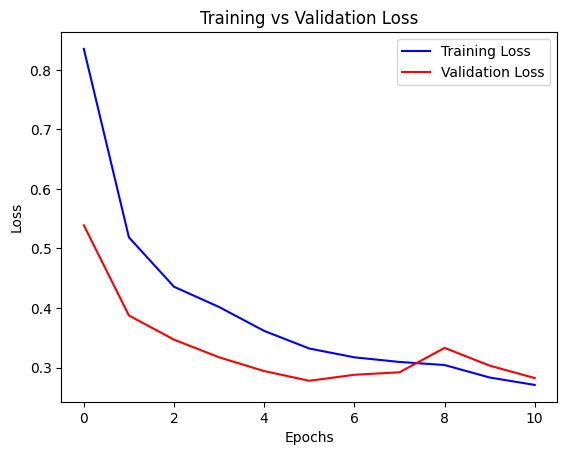

In [34]:
plot_losses(history_3)

### Conclusion: Increasing recurrent dropout impairs performance

## Model 4

### Increase Nodes to 8

In [37]:
# create model
model_4 = Sequential()
model_4.add(Input(shape=(max_words, embedding_size)))
model_4.add(LSTM(8, dropout=0.1, recurrent_dropout=0.2))
model_4.add(Dense(4, activation='sigmoid'))
model_4.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [38]:
history_4 = model_4.fit(train_x, train_y, epochs=40, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.5913 - loss: 1.0028 - val_acc: 0.8540 - val_loss: 0.4871
Epoch 2/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.8749 - loss: 0.4308 - val_acc: 0.9150 - val_loss: 0.3469
Epoch 3/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.8970 - loss: 0.3612 - val_acc: 0.9040 - val_loss: 0.3669
Epoch 4/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.8974 - loss: 0.3443 - val_acc: 0.9160 - val_loss: 0.3065
Epoch 5/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9116 - loss: 0.3148 - val_acc: 0.9240 - val_loss: 0.2935
Epoch 6/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9066 - loss: 0.3289 - val_acc: 0.9260 - val_loss: 0.2751
Epoch 7/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9171 - loss: 0.2947 - val_acc: 0.9240 - val_loss: 0.2714
Epoch 8/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9189 - loss: 0.2860 - val_acc: 0.9190 - val_loss: 0.2859
Epoch 9/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/

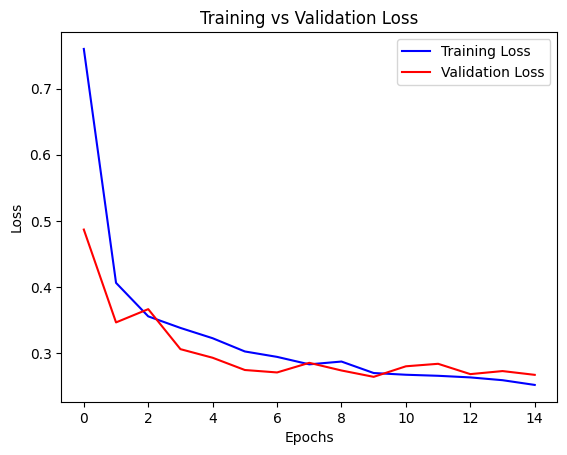

In [39]:
plot_losses(history_4)

### Conclusion: Adding nodes decreases performance

## Model 5

### Reduce dropout again

In [40]:
# create model
model_5 = Sequential()
model_5.add(Input(shape=(max_words, embedding_size)))
model_5.add(LSTM(6, dropout=0.05, recurrent_dropout=0.2))
model_5.add(Dense(4, activation='sigmoid'))
model_5.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [41]:
history_5 = model_5.fit(train_x, train_y, epochs=40, batch_size=8, validation_data=(val_x, val_y), callbacks=early_stopping)

Epoch 1/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.5448 - loss: 1.0885 - val_acc: 0.7940 - val_loss: 0.6122
Epoch 2/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.8505 - loss: 0.5149 - val_acc: 0.9060 - val_loss: 0.3568
Epoch 3/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.8873 - loss: 0.3813 - val_acc: 0.9070 - val_loss: 0.3434
Epoch 4/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.8988 - loss: 0.3548 - val_acc: 0.9190 - val_loss: 0.3014
Epoch 5/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9076 - loss: 0.3172 - val_acc: 0.9180 - val_loss: 0.2923
Epoch 6/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - acc: 0.9086 - loss: 0.3194 - val_acc: 0.9220 - val_loss: 0.2949
Epoch 7/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9152 - loss: 0.3022 - val_acc: 0.9180 - val_loss: 0.3062
Epoch 8/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - acc: 0.9244 - loss: 0.2654 - val_acc: 0.9250 - val_loss: 0.2873
Epoch 9/40
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/

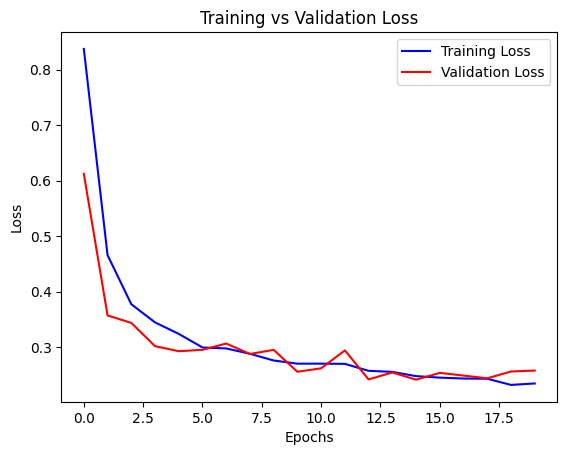

In [42]:
plot_losses(history_5)

### Conclusion: Reducing input dropout from 0.1 to 0.05 impairs performance. This may indicate that dropout causes underfitting

# Get Metrics on Test Set

In [44]:
from sklearn.metrics import classification_report, accuracy_score

In [45]:
y_pred = model_2.predict(test_x)

# Get Label with highest probability
y_pred = y_pred.argmax(axis=1)  

# Generate classification report
report = classification_report(test_y, y_pred, digits=4)  
accuracy = accuracy_score(test_y, y_pred)  

print(report)
print(f"Accuracy: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

           0     0.9323    0.9360    0.9341       250
           1     0.9352    0.9240    0.9296       250
           2     0.9339    0.9600    0.9467       250
           3     0.9755    0.9560    0.9657       250

    accuracy                         0.9440      1000
   macro avg     0.9442    0.9440    0.9440      1000
weighted avg     0.9442    0.9440    0.9440      1000

Accuracy: 0.9440
